<a href="https://colab.research.google.com/github/Sunflower47/Portfolio/blob/main/speckle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Задание

Известно, что для кодирование сообщения был использован код Баркера длиной 11, причём каждый его элемент повторен 5 раз, таким образом длина кодирующей последовательности равна 55. Декодируйте содержимое файла hello.txt в ASCII строку и запишите её в файл wifi.json в виде {"message": "Text"}.

Обработайте результаты спекл-наблюдений. Файл speckledata.fits содержит 101 последовательное изображение, полученные при фотографировании двойной звезды с короткой экспозицией. Вашей задачей является восстановление изображения двойной звезды с помощью его фильтрации в пространстве частот. Все изображения должны быть сохранены в корневую папку репозитория, иметь размер 512x512 пикселей и хорошо подобранный контраст.

#Код

##Импорт библиотек

In [187]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [188]:
import numpy as np
import json
import astropy.io.fits as fits
import matplotlib.pyplot as plt
from scipy.ndimage import rotate
import scipy

In [189]:
with open('hello.txt') as f:
    file = f.readlines()

##Декодировка кода Баркера

In [190]:
data = np.array(file, dtype=float)
code = np.array([+1, +1, +1, -1, -1, -1, +1, -1, -1, +1, -1], dtype=np.int8)
code_ = np.repeat(code, 5)

dc = np.convolve(data, code_[::-1], mode='full')
mean = np.mean(dc)
std = np.std(dc)

time = np.arange(dc.shape[0])
peaks = abs(dc) > (mean + 2*std)   
peaks_ind = np.nonzero(time[peaks][1::] - time[peaks][:-1:] != 1)
time_peaks = time[peaks][peaks_ind]
dc_peaks = dc[peaks][peaks_ind]
bytes_ = (np.asarray(np.sign(dc_peaks - mean), dtype=np.int8) + 1)/2
bits = np.packbits(np.asarray(bytes_, dtype=np.uint8))
a = bits.tobytes()
line = a.decode('ascii')
result = {"message": line}

In [191]:
with open('wifi.json', 'w') as f:
    json.dump(result, f)

##Обработка изображения и фильтрация частот

###Скачивание данных и усреднение

In [192]:
data = fits.open('speckledata.fits')[2].data
mean = np.mean(data, axis=0)

###Визуализация

In [ ]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
fig.get_dpi
plt.imshow(mean)
fig.savefig('mean.png')

###Вычисление спектра мощности случайного процесса (квадрат модуля его преобразования Фурье)

In [194]:
spectrum = np.abs(np.fft.fftshift(np.fft.fft2(data, s=None, axes=(-2, -1)))**2)
mean_spectrum = spectrum.mean(axis=0)


###Визуализация Фурье-образа

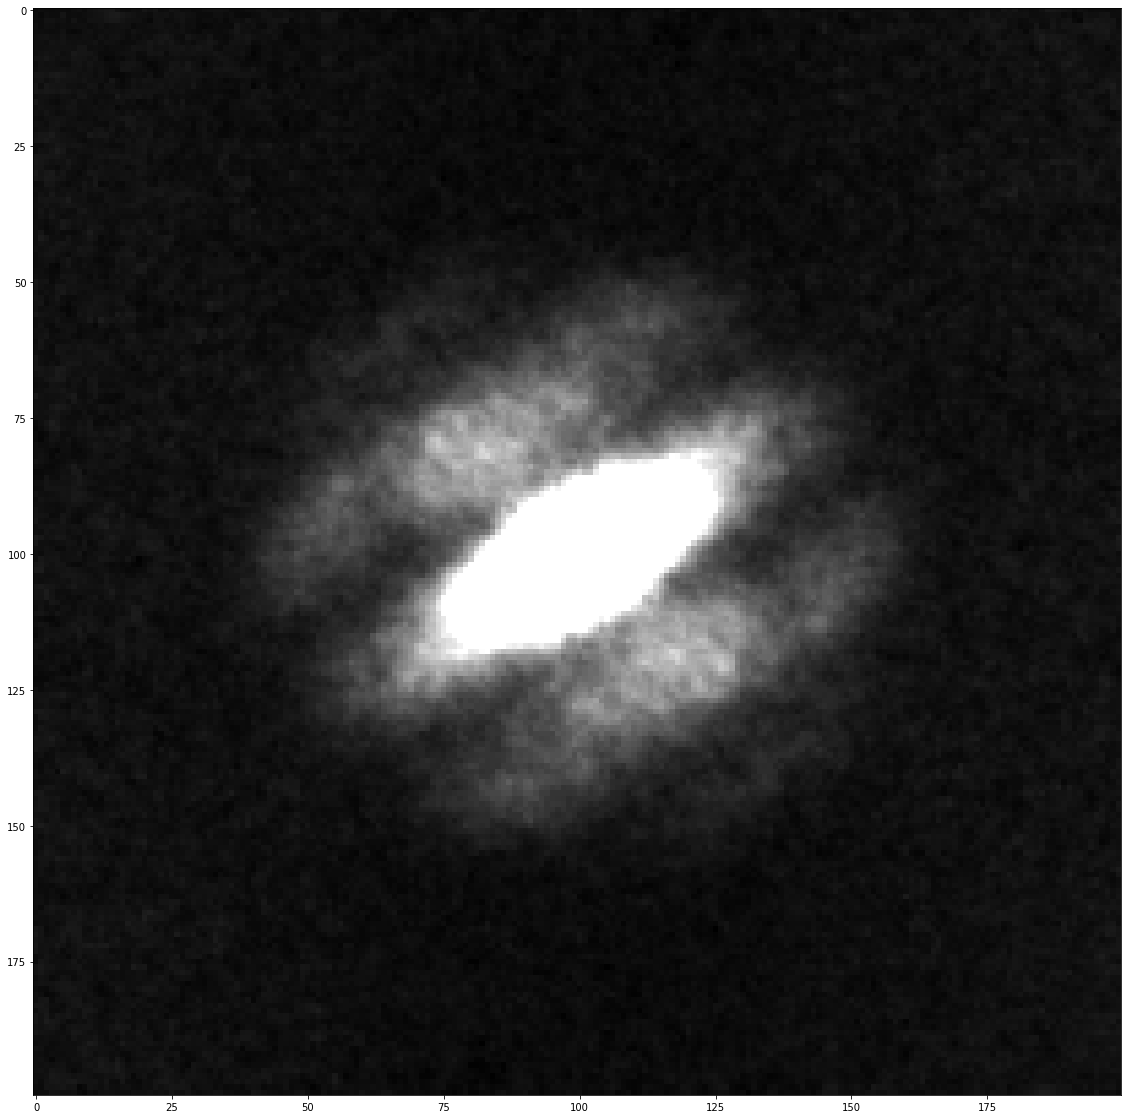

In [195]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
fig.get_dpi
plt.imshow(mean_spectrum, cmap="gray", vmin=np.min(mean_spectrum) , vmax=np.mean(mean_spectrum))
fig.savefig('fourier.png')

###Вычитание шумовой подложки

In [196]:
mask = np.zeros(mean_spectrum.shape)

for i in np.arange(len(mask)):
  for j in np.arange(len(mask)):
    if np.sqrt((i-100)**2 + (j-100)**2) <= 50:
      mask[i][j] = True
    else:
      mask[i][j] = False

noise = np.ma.masked_array(mean_spectrum, mask)
mean_noise = np.mean(noise.data)
cleared_spectrum = mean_spectrum - mean_noise


###Усреднение по углам

In [197]:
rotated_spectrum = np.zeros((200, 200))

for i in range(360):
  rotated_spectrum += rotate(noise, i, reshape=False)

isotropic_spectrum = rotated_spectrum/360


###Визуализация усредненной по углам картинки

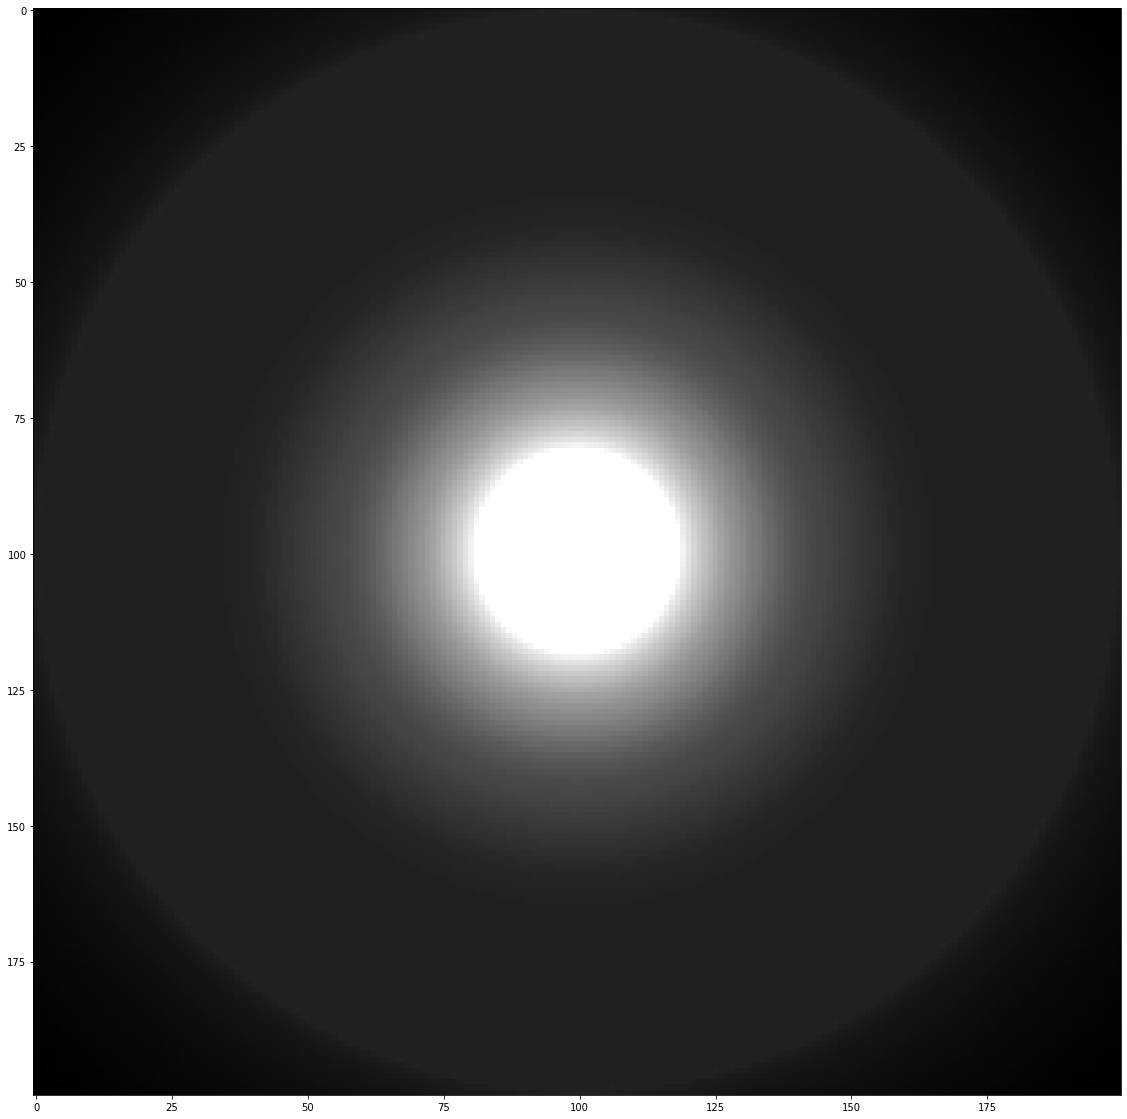

In [198]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
fig.get_dpi
plt.imshow(isotropic_spectrum, cmap="gray", vmin=np.min(isotropic_spectrum) , vmax=np.mean(isotropic_spectrum))
fig.savefig('rotaver.png')

###Обратное преобразование фурье

In [199]:
divided_spectrum = cleared_spectrum / isotropic_spectrum

for i in np.arange(len(mask)):
  for j in np.arange(len(mask)):
    if np.sqrt((i-100)**2 + (j-100)**2) <= 50:
      mask[i][j] = False
    else:
      mask[i][j] = True

clipped = np.ma.masked_array(divided_spectrum, mask).filled(0)

binary = np.fft.fftshift(np.abs(np.fft.ifft2(clipped, axes=(0, 1))))


###Визуализация итогового изображения

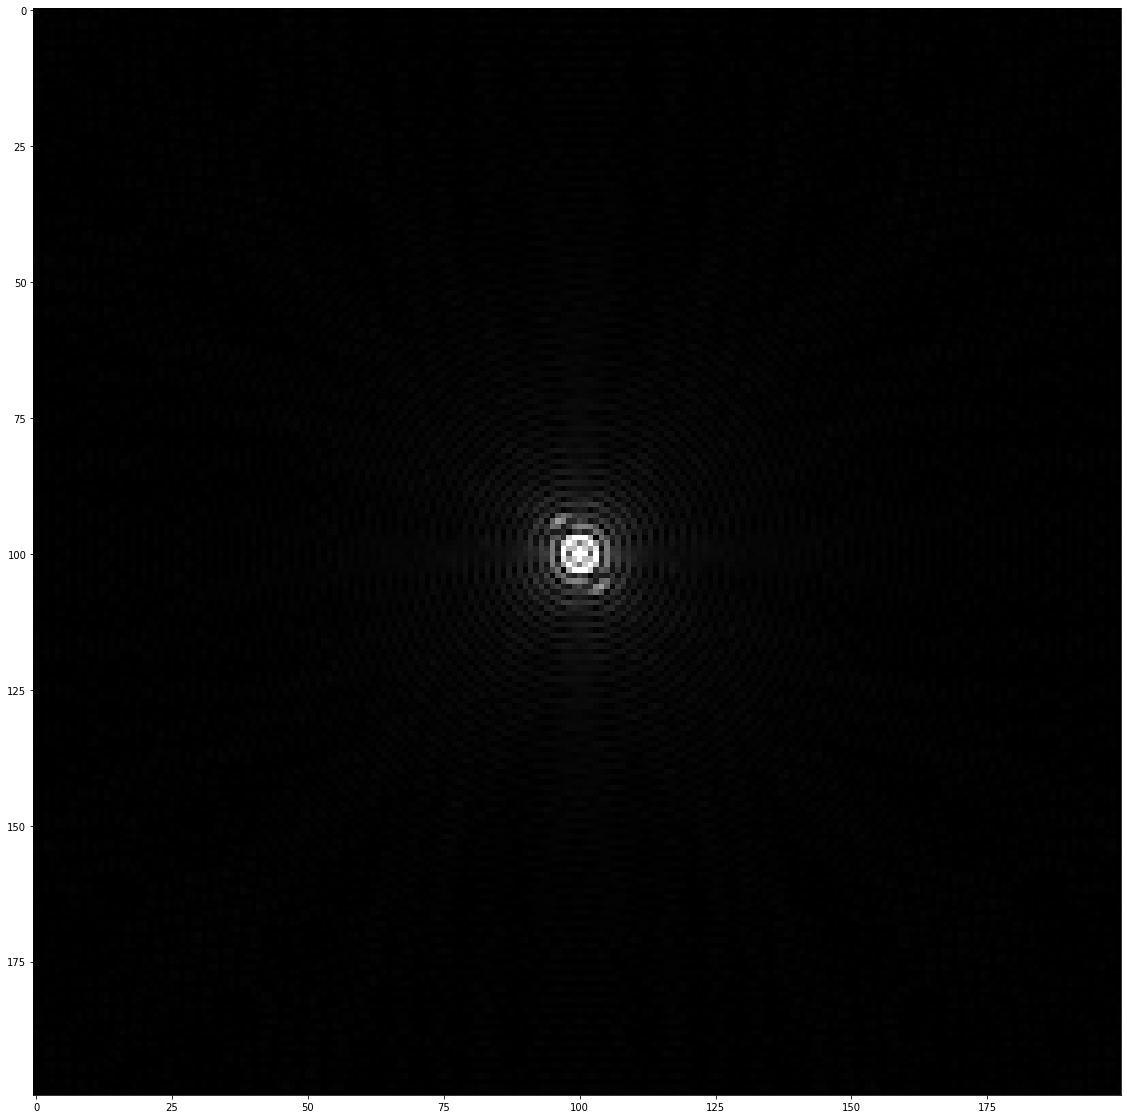

In [200]:
fig = plt.gcf()
fig.set_size_inches(20, 20)
fig.get_dpi
plt.imshow(binary, cmap="gray", vmin=0 , vmax=0.1)
fig.savefig('binary.png')